In [1]:
import numbers
from collections import Counter
from scipy.stats import mode
from sklearn.utils import _safe_indexing
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
import pandas as pd
import numpy as np
import seaborn as sns    
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                             accuracy_score, matthews_corrcoef, recall_score, 
                             precision_score, confusion_matrix)

In [2]:
df = pd.read_csv('D:/My Thesis/data in spss/imputed_Extra_tree .csv')
df = df.drop('ID' ,axis = 1)

In [3]:
X=df.drop('Hospital_outcome',axis=1)
y=df['Hospital_outcome']

In [4]:
categorical_features = ['Sex','Digestive_underlying', 'Respiratory_underlying','Infectious_underlying','Fatness_underlying', 'Urinary_underlying',
'Diabete_underlying', 'Highbloodpressure_underlying','Heart_underlying','Nervous_underlying', 'Blooddisease_underlying','Opiate', 'Education', 
'Urinary', 'Urinary_Incontinence', 'Previous_recurrent', 'Noconsious', 'GCS','Receivingblood', 'Conciousness', 'Patient_arrival', 'Time',
'Type_stroke', 'Treatment_method', 'Pneumonia', 'Convulsions','Individual', 'Motionless','Respiratory', 'Heart', 'Edema', 'Bloody',
'Vision_impairment', 'Sensory', 'Headache', 'Blurred_Vision','Reduce_strength_limb', 'Lackofbalance', 'Weakness', 'Delirium','Skin_problems',
'Aphasia_and_Dysarthria', 'Cranial_nerve_Disorder','Paralyzed', 'Digestive_problems']  # Replace with your categorical column names
numeric_features = ['Age','RR','HR','systolic','Lengthofhospitalization']
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=101
)

# OneHotEncoder

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

In [7]:
from sklearn.ensemble import IsolationForest
# Outlier detection (on training data only)
outlier_detector = IsolationForest(contamination=0.05, random_state=101)
outliers = outlier_detector.fit_predict(preprocessor.fit_transform(X_train))
inlier_mask = outliers != -1

In [8]:
# Apply outlier removal
X_train_clean, y_train_clean = X_train.iloc[inlier_mask], y_train.iloc[inlier_mask]

In [9]:
# Preprocess cleaned training data
X_train_preprocessed = preprocessor.transform(X_train_clean)

In [10]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import make_classification
# Initialize SVM-SMOTE
svm_smote = SVMSMOTE(random_state=101)
X_train_res, y_train_res = svm_smote.fit_resample(X_train_preprocessed, y_train_clean)

In [11]:
print("Class distribution before OSS:", Counter(y_train))
print("Class distribution after OSS:", Counter(y_train_res))

Class distribution before OSS: Counter({0: 1605, 1: 315})
Class distribution after OSS: Counter({0: 1560, 1: 1560})


# Create XGBoost-SVM-SMOTE.Model

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss',random_state=101)
param_grid = {
    'n_estimators': [10,20,50,100],        # Number of trees
    'max_depth': [3, 5, 7],                 # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],           # % samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],    # % features per tree
    'gamma': [0, 0.1, 0.2],                 # Min loss reduction for split
    'min_child_weight': [1, 3, 5]           # Minimum sum of instance weight
}
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,scoring='accuracy', cv=5,n_jobs=-1,verbose=1)
grid_search.fit(X_train_res, y_train_res )
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Score: 0.9314102564102564


In [13]:
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss',colsample_bytree=0.6,gamma=0.2,
learning_rate=0.1,max_depth=7, min_child_weight=1,n_estimators=50,subsample = 1.0,random_state=101)
xgb_model.fit(X_train_res, y_train_res )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
# Evaluate on test set
X_test_preprocessed = preprocessor.transform(X_test)

In [15]:
# Train the final model with the best parameters
y_pred = xgb_model.predict(X_test_preprocessed)
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)

In [16]:
# Evaluate best model REEN
accuracy = accuracy_score(y_test, y_pred)
print("\nOptimized Test Accuracy:",accuracy)


Optimized Test Accuracy: 0.875


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [18]:
# Convert confusion matrix to percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

In [19]:
# Print confusion matrix (counts)
print("Confusion Matrix (Counts):")
print(cm)

Confusion Matrix (Counts):
[[658  31]
 [ 72  63]]


In [20]:
# Print confusion matrix (percentages)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)


Confusion Matrix (Percentages):
[[95.50072569  4.49927431]
 [53.33333333 46.66666667]]


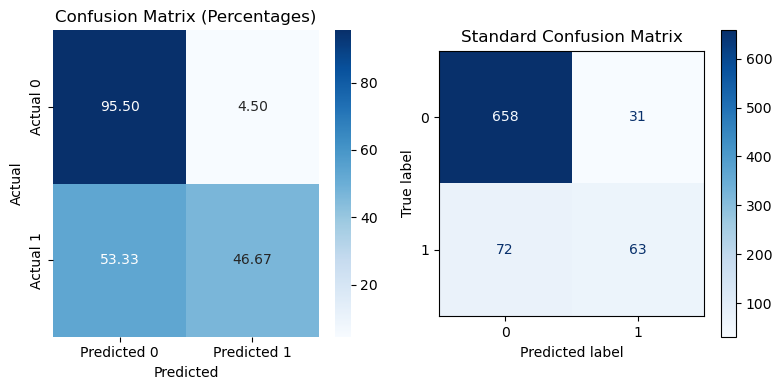

In [22]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Percentage confusion matrix (Seaborn)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Percentages)')

# Second plot: Standard confusion matrix (Scikit-learn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=xgb_model.classes_)
disp.plot(cmap='Blues', ax=ax2)
ax2.set_title('Standard Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [23]:
# Calculate and print the error rate and the number of misclassifications
err = 1 - accuracy_score(y_test, y_pred)
n_miss = np.sum(y_pred != y_test)
print(f"Error Rate: {err}")
print(f"Number of Misclassifications: {n_miss}")

Error Rate: 0.125
Number of Misclassifications: 103


In [24]:
from sklearn.metrics import classification_report
# Generate classification report 
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       689
           1       0.67      0.47      0.55       135

    accuracy                           0.88       824
   macro avg       0.79      0.71      0.74       824
weighted avg       0.86      0.88      0.87       824



In [25]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import matthews_corrcoef
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1_score = f1_score(y_test, y_pred)
# Print results
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"F1_measure: {f1_score:.3f}")
print(f"MCC: {mcc:.3f}")

Sensitivity (Recall): 0.467
Specificity: 0.955
G-mean: 0.668
F1_measure: 0.550
MCC: 0.491


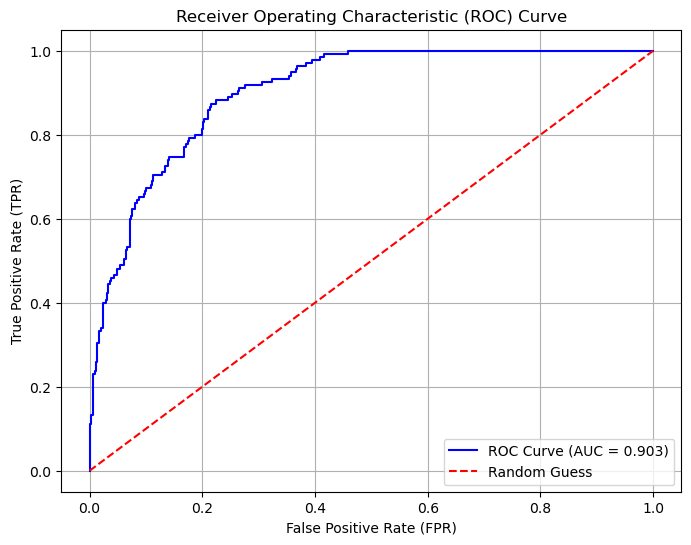

AUCROC: 0.903


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs, pos_label=xgb_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, xgb_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUCROC: {auc:.3f}')

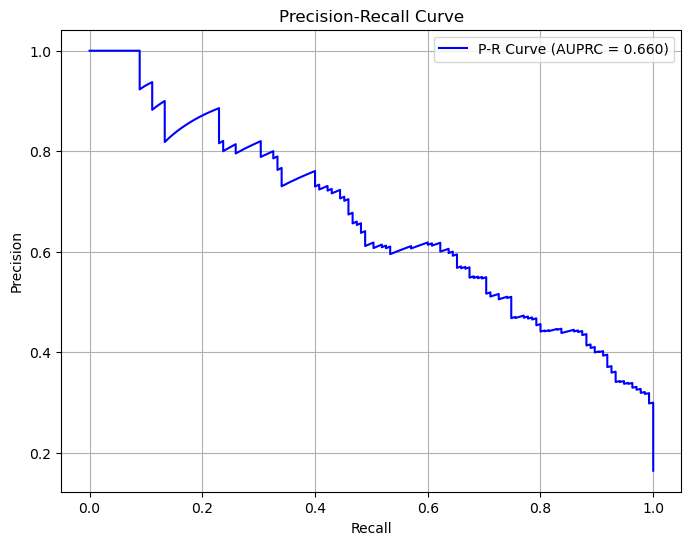

AUPRC: 0.660


In [27]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# For Keras: y_probs = model.predict(X_test).flatten()
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'AUPRC: {pr_auc:.3f}')